# Notebook:
### 1.Nearest neighbour (just to try)
### 2.Neural network

In [3]:
import pandas as pd
import numpy as np
import scipy as sp
import operator
import matplotlib.pyplot as plt
import seaborn as sns
import pickle


from IPython.display import display, Markdown
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import sklearn
from sklearn.metrics import classification_report
from sklearn.utils import resample


from collections import defaultdict
from collections import Counter


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# 1. Recommendation with NearestNeighbour

Two main parts: constructing a sparse matrix associated with users and animes and implementing a k-Nearest Neighbors (kNN) algorithm to discover similar animes

In [4]:
anime_df = pd.read_csv('archive/anime.csv')
non_float_ratings = anime_df[pd.to_numeric(anime_df['rating'], errors='coerce').isnull()]
non_integer_episodes = anime_df[pd.to_numeric(anime_df['episodes'], errors='coerce').isnull()]
index_to_drop = non_integer_episodes.index
anime_df.drop(index_to_drop, inplace=True)

rows_with_null_values = anime_df[anime_df.isna().any(axis=1)]
# Annahme: Überschriftstext
header_text = "Rows with NaN Values"
# Konvertiere den Text in Markdown
header_md = Markdown(f"## {header_text}")
# Zeige die Überschrift an
display(header_md)
display(rows_with_null_values)
anime_df.dropna(axis = 0, inplace = True)
anime_df.isna().sum()

## Rows with NaN Values

,anime_id,name,genre,type,episodes,rating,members
2844,33242,IS: Infinite Stratos 2 - Infinite Wedding,NaN,Special,1,7.15,6604
3541,33589,ViVid Strike!,NaN,TV,12,6.96,12345
6040,29765,Metropolis (2009),NaN,Movie,1,6.27,313
6646,32695,Match Shoujo,NaN,ONA,1,6.02,242
7018,33187,Katsudou Shashin,NaN,Movie,1,5.79,607
...,...,...,...,...,...,...,...
11111,34445,Yuuki Yuuna wa Yuusha de Aru: Yuusha no Shou,"Drama, Fantasy, Magic, Slice of Life",TV,6,NaN,4439
11112,33035,Yuyushiki Special,NaN,Special,1,NaN,2294
11113,33390,Zunda Horizon,NaN,Movie,1,NaN,160
12257,34168,Hataraku Otona no Renai Jijou The Animation,Hentai,OVA,1,NaN,331


anime_id    0
name        0
genre       0
type        0
episodes    0
rating      0
members     0
dtype: int64

In [5]:
rating_df = pd.read_csv('archive/rating.csv')
#rating_df = rating_df.set_index('user_id')
print("Anzahl der Zeilen im DataFrame:", rating_df.shape[0])

# Ausgabe der Anzahl der Zeilen im neuen DataFrame
print("Anzahl der Zeilen im DataFrame (50 Prozent):", rating_df.shape[0])

# Anzeige der ersten Zeilen des neuen DataFrames
rating_df

Anzahl der Zeilen im DataFrame: 7813737
Anzahl der Zeilen im DataFrame (50 Prozent): 7813737


,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1
...,...,...,...
7813732,73515,16512,7
7813733,73515,17187,9
7813734,73515,22145,10
7813735,73516,790,9


In [6]:
from scipy.sparse import csr_matrix

'''
Sparse matrix (CSR format) representing user ratings for various anime
'''

def mapper(df):

    M = df['user_id'].nunique()
    N = df['anime_id'].nunique()

    user_mapper = dict(zip(np.unique(df["user_id"]), list(range(M))))
    anime_mapper = dict(zip(np.unique(df["anime_id"]), list(range(N))))
    
    user_inv_mapper = dict(zip(list(range(M)), np.unique(df["user_id"])))
    anime_inv_mapper = dict(zip(list(range(N)), np.unique(df["anime_id"])))
    
    user_index = [user_mapper[i] for i in df['user_id']]
    item_index = [anime_mapper[i] for i in df['anime_id']]

    X = csr_matrix((df["rating"], (user_index,item_index)), shape=(M,N))
    
    return X, user_mapper, anime_mapper, user_inv_mapper, anime_inv_mapper

X, user_mapper, anime_mapper, user_inv_mapper, anime_inv_mapper = mapper(rating_df)

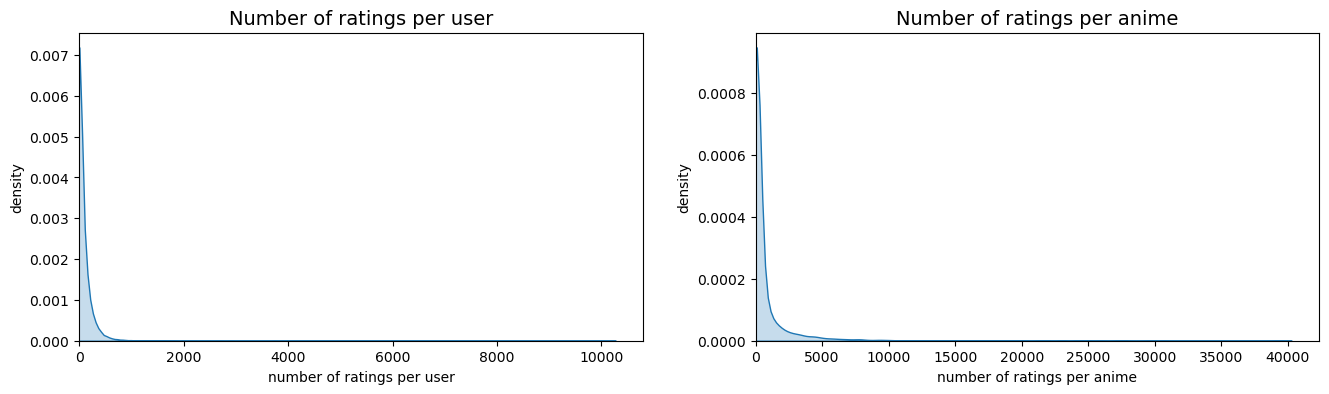

Matrix sparsity: 0.95%


In [7]:
n_total = X.shape[0]*X.shape[1]
n_ratings = X.nnz
sparsity = n_ratings/n_total
n_ratings_per_user = X.getnnz(axis=1)
n_ratings_per_anime = X.getnnz(axis=0)
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
sns.kdeplot(n_ratings_per_user, shade=True)
plt.xlim(0)
plt.title("Number of ratings per user", fontsize=14)
plt.xlabel("number of ratings per user")
plt.ylabel("density")
plt.subplot(1,2,2)
sns.kdeplot(n_ratings_per_anime, shade=True)
plt.xlim(0)
plt.title("Number of ratings per anime", fontsize=14)
plt.xlabel("number of ratings per anime")
plt.ylabel("density")
plt.savefig("Sparsity.png")

plt.show()
print(f"Matrix sparsity: {round(sparsity*100,2)}%")

In [8]:
from sklearn.neighbors import NearestNeighbors

'''
implements a method for finding similar anime using the k-Nearest Neighbors algorithm
'''


def find_similar_animes(anime_id, X, anime_mapper, anime_inv_mapper, k, metric='cosine'):
    X = X.T
    neighbour_ids = []
    anime_ind = anime_mapper[anime_id]
    anime_vec = X[anime_ind]
    if isinstance(anime_vec, (np.ndarray)):
        anime_vec = anime_vec.reshape(1,-1)
    kNN = NearestNeighbors(n_neighbors=k+1, algorithm="brute", metric=metric)
    kNN.fit(X)
    neighbour = kNN.kneighbors(anime_vec, return_distance=False)
    for i in range(0,k):
        n = neighbour.item(i)
        neighbour_ids.append(anime_inv_mapper[n])
    neighbour_ids.pop(0)
    return neighbour_ids

In [9]:
similar_animes = find_similar_animes(8, X, anime_mapper, anime_inv_mapper, k=10)
similar_animes

[1123, 613, 845, 238, 479, 246, 1536, 296, 1250]

In [10]:
anime_df.loc[8]

anime_id                                                15335
name        Gintama Movie: Kanketsu-hen - Yorozuya yo Eien...
genre       Action, Comedy, Historical, Parody, Samurai, S...
type                                                    Movie
episodes                                                    1
rating                                                    9.1
members                                                 72534
Name: 8, dtype: object

In [11]:
similar_animes_df = anime_df.loc[similar_animes]
print("\nSimilar Animes DataFrame:")
similar_animes_df


Similar Animes DataFrame:


,anime_id,name,genre,type,episodes,rating,members
1123,8841,Kore wa Zombie Desu ka?,"Action, Comedy, Ecchi, Harem, Magic, Supernatural",TV,12,7.67,295782
613,20517,Little Busters!: EX,"Comedy, Drama, Romance, School, Slice of Life,...",Special,8,7.94,26709
845,9471,Baka to Test to Shoukanjuu: Matsuri,"Comedy, School, Super Power",OVA,2,7.80,67684
238,239,Gankutsuou,"Drama, Mystery, Sci-Fi, Supernatural, Thriller",TV,24,8.27,103828
479,13331,Jormungand: Perfect Order,"Action, Adventure, Seinen",TV,12,8.04,81951
246,3167,Eve no Jikan,"Sci-Fi, Slice of Life",ONA,6,8.26,99074
1536,8460,Mirai Nikki,"Action, Shounen, Supernatural",OVA,1,7.51,114217
296,3016,Ginga Eiyuu Densetsu: Arata Naru Tatakai no Ov...,"Action, Drama, Military, Sci-Fi, Space",Movie,1,8.21,11808
1250,4981,Casshern Sins,"Action, Adventure, Drama, Psychological, Sci-Fi",TV,24,7.61,80307


# 2. Collaborative filtering with neural network (matrix factorization)

In [12]:
anime_df = pd.read_csv('archive/anime.csv')
non_float_ratings = anime_df[pd.to_numeric(anime_df['rating'], errors='coerce').isnull()]
non_integer_episodes = anime_df[pd.to_numeric(anime_df['episodes'], errors='coerce').isnull()]
index_to_drop = non_integer_episodes.index
anime_df.drop(index_to_drop, inplace=True)

rows_with_null_values = anime_df[anime_df.isna().any(axis=1)]
# Annahme: Überschriftstext
header_text = "Rows with NaN Values"
# Konvertiere den Text in Markdown
header_md = Markdown(f"## {header_text}")
# Zeige die Überschrift an
display(header_md)
display(rows_with_null_values)
anime_df.dropna(axis = 0, inplace = True)
anime_df.isna().sum()

## Rows with NaN Values

,anime_id,name,genre,type,episodes,rating,members
2844,33242,IS: Infinite Stratos 2 - Infinite Wedding,NaN,Special,1,7.15,6604
3541,33589,ViVid Strike!,NaN,TV,12,6.96,12345
6040,29765,Metropolis (2009),NaN,Movie,1,6.27,313
6646,32695,Match Shoujo,NaN,ONA,1,6.02,242
7018,33187,Katsudou Shashin,NaN,Movie,1,5.79,607
...,...,...,...,...,...,...,...
11111,34445,Yuuki Yuuna wa Yuusha de Aru: Yuusha no Shou,"Drama, Fantasy, Magic, Slice of Life",TV,6,NaN,4439
11112,33035,Yuyushiki Special,NaN,Special,1,NaN,2294
11113,33390,Zunda Horizon,NaN,Movie,1,NaN,160
12257,34168,Hataraku Otona no Renai Jijou The Animation,Hentai,OVA,1,NaN,331


anime_id    0
name        0
genre       0
type        0
episodes    0
rating      0
members     0
dtype: int64

In [13]:
print("Anzahl der Zeilen im DataFrame:", anime_df.shape[0])
anime_df.head()

Anzahl der Zeilen im DataFrame: 11830


,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [14]:
rating_df = pd.read_csv('archive/rating.csv')
print("Anzahl der Zeilen im DataFrame:", rating_df.shape[0])

anzahl_rating_minus_eins = (rating_df['rating'] == -1).sum()
print("Anzahl der Zeilen mit einem Rating von -1:", anzahl_rating_minus_eins)

rating_df = rating_df[rating_df['rating'] != -1]
anzahl_rating_minus_eins = (rating_df['rating'] == -1).sum()
print("Anzahl der Zeilen mit einem Rating von -1:", anzahl_rating_minus_eins)

print("Anzahl der Zeilen im DataFrame:", rating_df.shape[0])

rating_df.head()

Anzahl der Zeilen im DataFrame: 7813737
Anzahl der Zeilen mit einem Rating von -1: 1476496
Anzahl der Zeilen mit einem Rating von -1: 0
Anzahl der Zeilen im DataFrame: 6337241


,user_id,anime_id,rating
47,1,8074,10
81,1,11617,10
83,1,11757,10
101,1,15451,10
153,2,11771,10


#### Because of RAM issue i can not use all the data 

In [15]:
rating_df = rating_df.sample(frac=0.3, random_state=42) 
print("Anzahl der Zeilen im DataFrame (50 Prozent):", rating_df.shape[0])
rating_df.head()

Anzahl der Zeilen im DataFrame (50 Prozent): 1901172


,user_id,anime_id,rating
5656992,53103,6707,7
3552500,32884,339,8
2636208,24907,23755,9
5554182,52213,10156,7
95779,994,1562,10


In [16]:
# number of users for embeddings = 53424
num_users = rating_df.user_id.nunique()
print('num_users: ', num_users)

num_items = rating_df.anime_id.nunique()
print('num_items: ', num_items)


# determine min and max ratings
min_rating = min(rating_df["rating"])
print('min_rating: ', min_rating)
max_rating = max(rating_df["rating"])
print('max_rating: ', max_rating)
min_user_id = min(rating_df["user_id"])
print('min_user_id: ', min_user_id)
max_user_id = max(rating_df["user_id"])
print('max_user_id: ', max_user_id)
min_anime_id = min(rating_df["anime_id"])
print('min_anime_id: ', min_anime_id)
max_anime_id = max(rating_df["anime_id"])
print('max_anime_id: ', max_anime_id)

num_users:  64649
num_items:  8826
min_rating:  1
max_rating:  10
min_user_id:  1
max_user_id:  73515
min_anime_id:  1
max_anime_id:  34367


In [17]:
def create_id_mapping(column, reference_column=None):
    """
    Creates a mapping from unique values to numerical indices.

    Args:
        column (pd.Series): The column to be converted.
        reference_column (pd.Series, optional): Reference column for unique values (if available).

    Returns:
        tuple: A dictionary with the mapping, a numpy array with the converted values, and the number of unique values.
    """
    if reference_column is not None:
        unique_values = reference_column.unique()
    else:
        unique_values = column.unique()
    value_to_index = {value: index for index, value in enumerate(unique_values)}
    mapped_column = np.array([value_to_index.get(value, -1) for value in column])
    return value_to_index, mapped_column, len(unique_values)

def encode_user_item_ids(dataframe, reference_dataframe=None):
    """
    Encodes the user and item IDs into numerical indices.

    Args:
        dataframe (pd.DataFrame): The dataframe to be encoded.
        reference_dataframe (pd.DataFrame, optional): Reference dataframe for encoding (if available).

    Returns:
        pd.DataFrame: The encoded dataframe.
    """
    dataframe = dataframe.copy()
    for column_name in ['user_id', 'anime_id']:
        reference_column = None
        if reference_dataframe is not None:
            reference_column = reference_dataframe[column_name]
        _, encoded_column, _ = create_id_mapping(dataframe[column_name], reference_column)
        dataframe[column_name] = encoded_column
        dataframe = dataframe[dataframe[column_name] >= 0]
    return dataframe

In [18]:
# Random split for training, validation, and test sets
np.random.seed(3)
mask = np.random.rand(len(rating_df)) < 0.8
train = rating_df[mask].copy()
valid = rating_df[~mask].copy()
test_valid_split = np.array_split(valid, 2)
valid = test_valid_split[0]
test = test_valid_split[1]

# Number of unique users and items
num_users_total = rating_df.user_id.nunique()
num_items_total = rating_df.anime_id.nunique()

# Encoding the training, validation, and test data
train_ratings = encode_user_item_ids(train)
valid_ratings = encode_user_item_ids(valid, train)
test_ratings = encode_user_item_ids(test)

In [19]:
def plot_rating_distribution(ratings, title, filename):
    unique_ratings, counts = torch.unique(ratings, return_counts=True)

    for rating, count in zip(unique_ratings, counts):
        print(f"Rating: {rating.item()}, Count: {count.item()}")

    plt.bar(unique_ratings.numpy(), counts.numpy())
    plt.xlabel('Rating')
    plt.ylabel('Count')
    plt.title(title)
    plt.savefig(filename)
    plt.show()

Rating: 1.0, Count: 3965
Rating: 2.0, Count: 5522
Rating: 3.0, Count: 9906
Rating: 4.0, Count: 24990
Rating: 5.0, Count: 67949
Rating: 6.0, Count: 153454
Rating: 7.0, Count: 329663
Rating: 8.0, Count: 394232
Rating: 9.0, Count: 300523
Rating: 10.0, Count: 229290


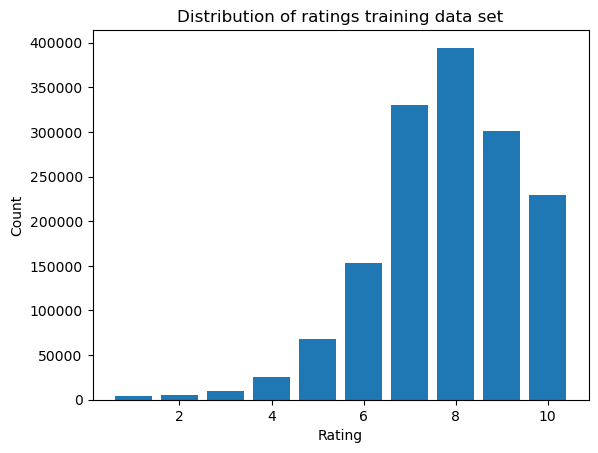

Rating: 1.0, Count: 510
Rating: 2.0, Count: 716
Rating: 3.0, Count: 1161
Rating: 4.0, Count: 3149
Rating: 5.0, Count: 8607
Rating: 6.0, Count: 19142
Rating: 7.0, Count: 41341
Rating: 8.0, Count: 49290
Rating: 9.0, Count: 37963
Rating: 10.0, Count: 28960


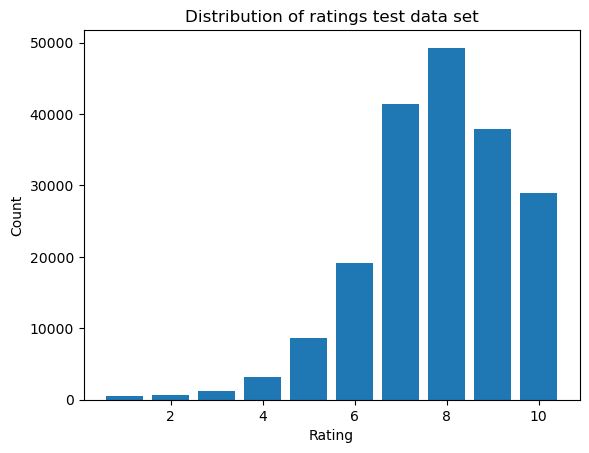

In [20]:
train_ratings_tensor = torch.FloatTensor(train_ratings.rating.values)
plot_rating_distribution(train_ratings_tensor, 'Distribution of ratings training data set', 'Distribution_ratings_train.png')

test_ratings_tensor = torch.FloatTensor(test_ratings.rating.values)
plot_rating_distribution(test_ratings_tensor, 'Distribution of ratings test data set', 'Distribution_ratings_test.png')

In [19]:
# Uncomment this to create a balanced data set
'''

def encode_and_balance_data(dataframe, reference_dataframe=None):
    """
    Encodes the user and item IDs into numerical indices and balances the ratings distribution.

    Args:
        dataframe (pd.DataFrame): The dataframe to be encoded and balanced.
        reference_dataframe (pd.DataFrame, optional): Reference dataframe for encoding (if available).

    Returns:
        pd.DataFrame: The encoded and balanced dataframe.
    """
    dataframe = dataframe.copy()
    
    # Encode user_id and anime_id columns
    for column_name in ['user_id', 'anime_id']:
        reference_column = None
        if reference_dataframe is not None:
            reference_column = reference_dataframe[column_name]
        _, encoded_column, _ = create_id_mapping(dataframe[column_name], reference_column)
        dataframe[column_name] = encoded_column
        dataframe = dataframe[dataframe[column_name] >= 0]

    # Balance the ratings distribution
    ratings = torch.FloatTensor(dataframe.rating.values)
    unique_ratings, counts = torch.unique(ratings, return_counts=True)
    min_count = counts.min().item()

    balanced_dfs = []
    for rating in unique_ratings.numpy():
        rating_df = dataframe[dataframe['rating'] == rating]
        downsampled_df = resample(rating_df, replace=False, n_samples=min_count, random_state=42)
        balanced_dfs.append(downsampled_df)
    
    balanced_dataframe = pd.concat(balanced_dfs).sample(frac=1, random_state=42).reset_index(drop=True)
    
    return balanced_dataframe

# Random split for training, validation, and test sets
np.random.seed(3)
mask = np.random.rand(len(rating_df)) < 0.8
train = rating_df[mask].copy()
valid = rating_df[~mask].copy()
test_valid_split = np.array_split(valid, 2)
valid = test_valid_split[0]
test = test_valid_split[1]

# Number of unique users and items
num_users_total = rating_df.user_id.nunique()
num_items_total = rating_df.anime_id.nunique()

# Encoding and balancing the training, validation, and test data
train_ratings = encode_and_balance_data(train)
valid_ratings = encode_and_balance_data(valid, train)
test_ratings = encode_and_balance_data(test, train)

# Plot distribution of training and test ratings
train_ratings_tensor = torch.FloatTensor(train_ratings.rating.values)
plot_rating_distribution(train_ratings_tensor, 'Distribution of Ratings - Training Dataset', 'Balanced_Distribution_ratings_train.png')

test_ratings_tensor = torch.FloatTensor(test_ratings.rating.values)
plot_rating_distribution(test_ratings_tensor, 'Distribution of Ratings - Test Dataset', 'Balanced_Distribution_ratings_test.png')
'''


'\n\ndef encode_and_balance_data(dataframe, reference_dataframe=None):\n    """\n    Encodes the user and item IDs into numerical indices and balances the ratings distribution.\n\n    Args:\n        dataframe (pd.DataFrame): The dataframe to be encoded and balanced.\n        reference_dataframe (pd.DataFrame, optional): Reference dataframe for encoding (if available).\n\n    Returns:\n        pd.DataFrame: The encoded and balanced dataframe.\n    """\n    dataframe = dataframe.copy()\n    \n    # Encode user_id and anime_id columns\n    for column_name in [\'user_id\', \'anime_id\']:\n        reference_column = None\n        if reference_dataframe is not None:\n            reference_column = reference_dataframe[column_name]\n        _, encoded_column, _ = create_id_mapping(dataframe[column_name], reference_column)\n        dataframe[column_name] = encoded_column\n        dataframe = dataframe[dataframe[column_name] >= 0]\n\n    # Balance the ratings distribution\n    ratings = torch.Fl

In [20]:
test_ratings

,user_id,anime_id,rating
6399911,0,0,8
1267061,1,1,9
6144086,2,2,5
5734649,3,3,8
5894991,4,4,8
...,...,...,...
3980209,34526,27,9
5967794,20558,452,7
1524325,1542,6211,10
1097866,16154,281,8


In [21]:
class RecommenderNet(nn.Module):
    def __init__(self, num_users, num_items, embedding_size=100, n_hidden=10):
        """
        Initialize the RecommenderNet model.

        Args:
            num_users (int): Number of unique users.
            num_items (int): Number of unique items (animes).
            embedding_size (int): Size of the embedding vectors for users and items.
            n_hidden (int): Number of hidden layers (not used in this example).
        """
        super(RecommenderNet, self).__init__()
        self.user_embedding = nn.Embedding(num_users, embedding_size)
        self.item_embedding = nn.Embedding(num_items, embedding_size)
        self.hidden_layer1 = nn.Linear(embedding_size * 2, 128)
        self.hidden_layer2 = nn.Linear(128, 64)
        self.output_layer = nn.Linear(64, 1)
        self.dropout = nn.Dropout(0.1)

    def forward(self, user, item):
        """
        Forward pass of the model.

        Args:
            user (Tensor): Tensor of user IDs.
            item (Tensor): Tensor of item (anime) IDs.

        Returns:
            Tensor: Predicted rating.
        """
        user_vector = self.user_embedding(user)
        item_vector = self.item_embedding(item)
        x = F.relu(torch.cat([user_vector, item_vector], dim=1))
        x = self.dropout(x)
        x = F.relu(self.hidden_layer1(x))
        x = self.dropout(x)
        x = F.relu(self.hidden_layer2(x))
        x = self.output_layer(x)
        return x

    def recommend_user_animes(self, user_id, n):
        """
        Recommend top n animes for a given user.

        Args:
            user_id (int): User ID for which to generate recommendations.
            n (int): Number of top recommendations to return.

        Returns:
            pd.DataFrame: DataFrame of recommended animes with recommender scores.
        """
        if user_id > max_user_id or user_id < min_user_id:
            raise ValueError("Invalid user ID")
        
        anime_ids = torch.tensor(rating_df['anime_id'].unique().tolist()) - 1
        user_ids = torch.tensor([user_id])
        num_animes = anime_ids.shape[0]
        user_ids = user_ids.repeat(num_animes)
        
        # Get predictions for all animes for the given user
        predictions = self.forward(user_ids, anime_ids)
        predictions = np.array([pred.item() for pred in predictions])
        
        # Normalize the predictions
        min_score = predictions.min()
        max_score = predictions.max()
        range_score = max_score - min_score
        normalized_predictions = (predictions - min_score) / range_score
        
        # Map predictions to anime IDs
        anime_ids = rating_df.anime_id.unique()
        normalized_predictions = normalized_predictions.tolist()
        predictions = list(zip(normalized_predictions, anime_ids))
        
        # Filter out animes the user has already seen
        user_seen_animes = rating_df[rating_df.user_id == user_id]
        seen_anime_ids = set(user_seen_animes.anime_id)
        unseen_animes = [anime for anime in predictions if anime[1] not in seen_anime_ids]
        
        # Sort and select top n animes
        unseen_animes = sorted(unseen_animes, key=lambda x: x[0], reverse=True)
        top_n_animes = unseen_animes[:n]
        top_n_anime_ids = [anime[1] for anime in top_n_animes]
        top_n_anime_scores = [anime[0] for anime in top_n_animes]
        
        # Prepare the DataFrame of recommended animes
        recommended_animes = anime_df[anime_df["anime_id"].isin(top_n_anime_ids)]
        recommended_animes['recommender_score'] = top_n_anime_scores
        recommended_animes = recommended_animes.sort_values(by='recommender_score', ascending=False)
        return recommended_animes

In [22]:
model = RecommenderNet(max_user_id, max_anime_id, embedding_size=100)
print('Model: ', model)
total_params = sum(p.numel() for p in model.parameters())
print("Number of parameters:", total_params)

Model:  RecommenderNet(
  (user_embedding): Embedding(73515, 100)
  (item_embedding): Embedding(34367, 100)
  (hidden_layer1): Linear(in_features=200, out_features=128, bias=True)
  (hidden_layer2): Linear(in_features=128, out_features=64, bias=True)
  (output_layer): Linear(in_features=64, out_features=1, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)
Number of parameters: 10822249


In [23]:
def train_epochs(model, epochs=100, learning_rate=0.01, weight_decay=0.0, use_unsqueeze=False):
    """
    Train the model for a specified number of epochs.

    Parameters:
    model (torch.nn.Module): The neural network model to be trained.
    epochs (int): The number of training epochs.
    learning_rate (float): The learning rate for the optimizer.
    weight_decay (float): The weight decay (L2 penalty) for the optimizer.
    use_unsqueeze (bool): Whether to unsqueeze the ratings tensor.
    """
    # Initialize the Adam optimizer with the specified learning rate and weight decay
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    model.train()  # Set the model to training mode

    # Lists to store training and test loss values for each epoch
    training_losses = []
    test_losses = []

    for epoch in range(epochs):
        # Convert user, anime, and rating data to tensors
        user_ids = torch.LongTensor(train_ratings.user_id.values)
        anime_ids = torch.LongTensor(train_ratings.anime_id.values)
        ratings = torch.FloatTensor(train_ratings.rating.values)
        
        if use_unsqueeze:
            ratings = ratings.unsqueeze(1)
        
        # Make predictions using the model
        predictions = model(user_ids, anime_ids)
        
        # Calculate the loss using Mean Squared Error Loss
        criterion = nn.MSELoss()
        loss = torch.sqrt(criterion(predictions, ratings))
        
        # Zero the gradients, perform backpropagation, and update the weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Record the training loss for this epoch
        training_losses.append(loss.item())
        
        # Calculate the test loss for this epoch
        test_loss_value = calculate_test_loss(model, use_unsqueeze)
        test_losses.append(test_loss_value)
        
        # Print loss values every 10 epochs
        if epoch % 10 == 0:
            print(f"Epoch: {epoch}, Training Loss: {loss.item()}")
            print(f"Test Loss: {test_loss_value:.3f}")
    
    # Plot training and test loss values
    plt.plot(range(1, epochs + 1), training_losses, label='Training Loss')
    plt.plot(range(1, epochs + 1), test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Test Loss Over Epochs')
    plt.legend()
    plt.savefig('training_test_loss.png')
    plt.show()


def calculate_test_loss(model, use_unsqueeze=False):
    """
    Calculate the test loss for the model.

    Parameters:
    model (torch.nn.Module): The neural network model to be evaluated.
    use_unsqueeze (bool): Whether to unsqueeze the ratings tensor.

    Returns:
    float: The test loss value.
    """
    model.eval()  # Set the model to evaluation mode
    
    # Convert validation user, anime, and rating data to tensors
    user_ids = torch.LongTensor(valid_ratings.user_id.values)
    anime_ids = torch.LongTensor(valid_ratings.anime_id.values)
    ratings = torch.FloatTensor(valid_ratings.rating.values)
    
    if use_unsqueeze:
        ratings = ratings.unsqueeze(1)
    
    # Make predictions using the model
    predictions = model(user_ids, anime_ids)
    
    # Calculate the loss using Mean Squared Error Loss
    criterion = nn.MSELoss()
    loss = torch.sqrt(criterion(predictions, ratings))
    
    return loss.item()

Epoch: 0, Training Loss: 8.120931625366211
Test Loss: 7.565
Epoch: 10, Training Loss: 1.9918771982192993
Test Loss: 2.539
Epoch: 20, Training Loss: 1.971291422843933
Test Loss: 1.788
Epoch: 30, Training Loss: 1.8629238605499268
Test Loss: 1.794
Epoch: 40, Training Loss: 1.7984747886657715
Test Loss: 1.788
Epoch: 50, Training Loss: 1.7941783666610718
Test Loss: 1.797
Epoch: 60, Training Loss: 1.7967172861099243
Test Loss: 1.794
Epoch: 70, Training Loss: 1.7949838638305664
Test Loss: 1.793
Epoch: 80, Training Loss: 1.792573094367981
Test Loss: 1.791
Epoch: 90, Training Loss: 1.7830814123153687
Test Loss: 1.780


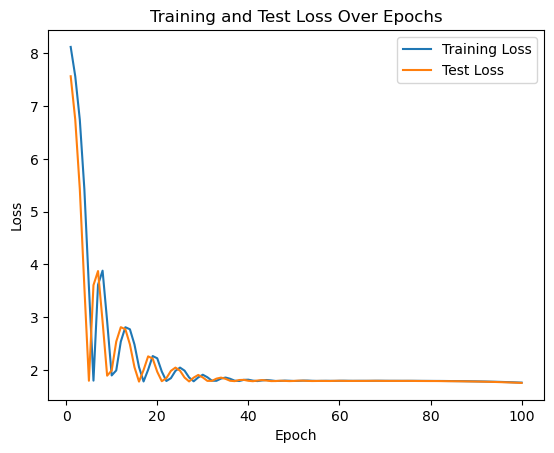

In [24]:
train_epochs(model, epochs=100, learning_rate=0.005, weight_decay=0.01, use_unsqueeze=True)

In [26]:
recommendation = model.recommend_user_animes(2000, 8)

In [27]:
recommendation

,anime_id,name,genre,type,episodes,rating,members,recommender_score
432,2752,Prince of Tennis: The National Tournament Semi...,"Action, Comedy, Sports",OVA,6,8.09,21186,1.000000
1054,6152,Final Fantasy VII: Advent Children - Venice Fi...,"Action, Drama, Fantasy, Sci-Fi",Movie,1,7.70,6498,0.951464
1521,30869,Ajin Part 2: Shoutotsu,"Action, Horror, Mystery, Seinen, Supernatural",Movie,1,7.51,11377,0.896632
1626,33241,Honobono Log,"Romance, Slice of Life",TV,10,7.48,9053,0.875093
1983,6713,Ranma ½: Nettou Uta Gassen,"Comedy, Music",OVA,2,7.39,3676,0.860786
6532,11543,Hate You,Music,Music,1,6.07,1222,0.859361
8337,31236,Chieri to Cherry,"Adventure, Fantasy, Shoujo",Movie,1,6.00,180,0.856490
11326,10457,JK to Inkou Kyoushi 4,Hentai,OVA,2,6.82,3914,0.850103


# Test

In [28]:
test_users = torch.LongTensor(test_ratings.user_id.values)
test_animes = torch.LongTensor(test_ratings.anime_id.values)
test_predictions = model(test_users, test_animes)
predicted_values = test_predictions.detach().numpy()
predicted_labels = np.round(predicted_values).astype(int)
print('predicted_labels: ', predicted_labels)
print('predicted_labels: ', type(predicted_labels))
print('predicted_labels: ', len(predicted_labels))



ground_truth = test_ratings.rating
print('ground_truth: ', ground_truth)
print('ground_truth: ', type(ground_truth))
print('ground_truth: ', len(ground_truth))



predicted_labels:  [[7]
 [7]
 [7]
 ...
 [7]
 [9]
 [9]]
predicted_labels:  <class 'numpy.ndarray'>
predicted_labels:  190839
ground_truth:  6399911     8
1267061     9
6144086     5
5734649     8
5894991     8
           ..
3980209     9
5967794     7
1524325    10
1097866     8
1415882     7
Name: rating, Length: 190839, dtype: int64
ground_truth:  <class 'pandas.core.series.Series'>
ground_truth:  190839


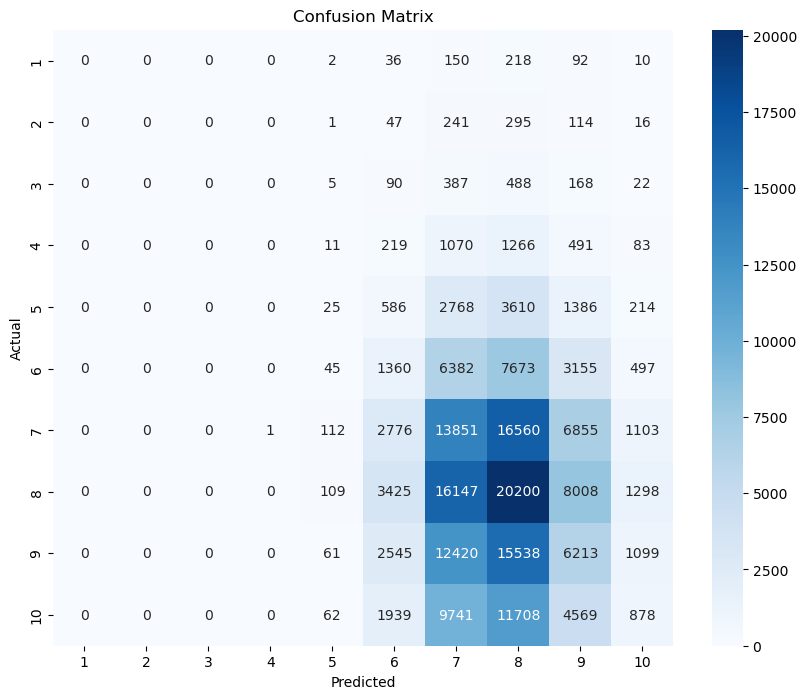

In [29]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(ground_truth, predicted_labels, labels=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], yticklabels=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')

plt.show()